# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [74]:
# import libraries
from pyspark import SparkContext, SparkConf


from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, datediff, 
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Creating Features") \
    .getOrCreate()

data = "mini_sparkify_event_data.json"



In [4]:
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
#Load data
event_data = spark.read.json(data)

In [45]:
#Check schema
event_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
#Check data entries
event_data.show(n=1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [8]:
#Checking for invalid or missing data with focus on userID and sessionID
#Check for NAN values in all columns

nan_dict = dict()
for col in event_data.columns:
    nan_dict[col] = event_data.filter(event_data[col].isNull()).count()
    
nan_dict

{'artist': 58392,
 'auth': 0,
 'firstName': 8346,
 'gender': 8346,
 'itemInSession': 0,
 'lastName': 8346,
 'length': 58392,
 'level': 0,
 'location': 8346,
 'method': 0,
 'page': 0,
 'registration': 8346,
 'sessionId': 0,
 'song': 58392,
 'status': 0,
 'ts': 0,
 'userAgent': 8346,
 'userId': 0}

In [18]:
#There are no nan values in userID or sessionID. 
#But we find a hughe amount of nan values in the other columns. Especially in the artists column

In [9]:
#Check for emptie user entries

empty_dict = dict()

for col in event_data.columns:
    empty_dict[col] = event_data.filter(event_data[col]=="").count()
empty_dict

{'artist': 0,
 'auth': 0,
 'firstName': 0,
 'gender': 0,
 'itemInSession': 0,
 'lastName': 0,
 'length': 0,
 'level': 0,
 'location': 0,
 'method': 0,
 'page': 0,
 'registration': 0,
 'sessionId': 0,
 'song': 0,
 'status': 0,
 'ts': 0,
 'userAgent': 0,
 'userId': 8346}

In [ ]:
#Many entries with no userID / no missing entires in session ID

In [ ]:
#Strategy is to remove all rows with no userID 

In [10]:
data_clean = event_data.filter(event_data["userId"]!="")

In [11]:
empty_dict = dict()

for col in data_clean.columns:
    empty_dict[col] = data_clean.filter(data_clean[col]=="").count()
empty_dict

{'artist': 0,
 'auth': 0,
 'firstName': 0,
 'gender': 0,
 'itemInSession': 0,
 'lastName': 0,
 'length': 0,
 'level': 0,
 'location': 0,
 'method': 0,
 'page': 0,
 'registration': 0,
 'sessionId': 0,
 'song': 0,
 'status': 0,
 'ts': 0,
 'userAgent': 0,
 'userId': 0}

In [12]:
nan_dict = dict()
for col in data_clean.columns:
    nan_dict[col] = data_clean.filter(data_clean[col].isNull()).count()
    
nan_dict

{'artist': 50046,
 'auth': 0,
 'firstName': 0,
 'gender': 0,
 'itemInSession': 0,
 'lastName': 0,
 'length': 50046,
 'level': 0,
 'location': 0,
 'method': 0,
 'page': 0,
 'registration': 0,
 'sessionId': 0,
 'song': 50046,
 'status': 0,
 'ts': 0,
 'userAgent': 0,
 'userId': 0}

In [ ]:
#still 3 columns with siginificatn amount of nans (3 cols with ~20%of data missing)

In [53]:
#Change ts and registration in date and time in string format from his unix apperance 

#Create user defined function 
#Convert unix timestamp in datetime format
get_datetime = udf(lambda x: datetime.datetime.utcfromtimestamp(x/1000.0).strftime("%d.%m.%Y %H:%M:%S"))

data_clean = data_clean.withColumn("timestamp", get_datetime(data_clean["ts"]))

In [51]:
data_clean.describe("timestamp").show()

+-------+
|summary|
+-------+
|  count|
|   mean|
| stddev|
|    min|
|    max|
+-------+



In [81]:
data_clean.toPandas().head(2)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,song,status,ts,userAgent,userId,timestamp,registationtime,membership_duration,churned,days_of_membership
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,...,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,01.10.2018 00:01:57,28.09.2018 22:22:42,2,0,2
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,01.10.2018 00:03:00,30.09.2018 18:20:30,0,0,0


In [44]:
#Do same for registration time
data_clean = data_clean.withColumn("registationtime", get_datetime(data_clean["registration"]))

In [16]:
data_clean.describe("registationtime").show()

+-------+-------------------+
|summary|    registationtime|
+-------+-------------------+
|  count|             278154|
|   mean|               null|
| stddev|               null|
|    min|01.08.2018 05:45:30|
|    max|30.10.2018 23:03:28|
+-------+-------------------+



In [48]:
data_clean.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- registationtime: string (nullable = true)
 |-- membership_duration: integer (nullable = true)
 |-- churned: integer (nullable = true)



In [78]:
# https://sparkbyexamples.com/pyspark/pyspark-difference-between-two-dates-days-months-years/
#Calculate Datedif between registration and ts time
###Not working????
data_clean = data_clean.withColumn("membership_duration", datediff(data_clean["registationtime"], data_clean["timestamp"]))

In [79]:
data_clean.describe("membership_duration").show()

+-------+-------------------+
|summary|membership_duration|
+-------+-------------------+
|  count|                  0|
|   mean|               null|
| stddev|               null|
|    min|               null|
|    max|               null|
+-------+-------------------+



In [80]:



get_duration = udf(lambda start,end: float((start-end)/(1000*60*60*24)))

# Apply the User Defined Function to the ts variable

data_clean = data_clean.withColumn("membership_duration", get_duration(data_clean["ts"], data_clean["registration"]))
data_clean = data_clean.withColumn("membership_duration", data_clean["membership_duration"].cast(IntegerType()))



In [65]:
data_clean.dtypes

[('artist', 'string'),
 ('auth', 'string'),
 ('firstName', 'string'),
 ('gender', 'string'),
 ('itemInSession', 'bigint'),
 ('lastName', 'string'),
 ('length', 'double'),
 ('level', 'string'),
 ('location', 'string'),
 ('method', 'string'),
 ('page', 'string'),
 ('registration', 'bigint'),
 ('sessionId', 'bigint'),
 ('song', 'string'),
 ('status', 'bigint'),
 ('ts', 'bigint'),
 ('userAgent', 'string'),
 ('userId', 'string'),
 ('timestamp', 'string'),
 ('registationtime', 'string'),
 ('membership_duration', 'int'),
 ('churned', 'int')]

In [82]:
# Update temporary view
data_clean.createOrReplaceTempView("user_log_table")

In [83]:
df_days_of_membership = spark.sql('''
        SELECT DISTINCT userId, MAX(membership_duration) AS duration_of_membership_in_days
        FROM user_log_table
        GROUP BY userId
        
        ''').toPandas().dropna()

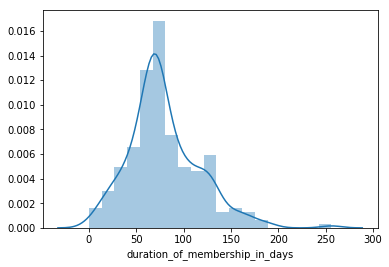

In [84]:
sns.distplot(df_days_of_membership.duration_of_membership_in_days);

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [23]:
# Create the view 'user_logs' or update this view if it already exists
data_clean.createOrReplaceTempView("user_logs")

In [24]:
spark.sql("""
    SELECT DISTINCT(*)
    FROM user_logs
    LIMIT 1
""").show()

+------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+-------------+------+-------------+--------------------+------+-------------------+-------------------+-------------------+
|artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|         song|status|           ts|           userAgent|userId|          timestamp|    registationtime|membership_duration|
+------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+-------------+------+-------------+--------------------+------+-------------------+-------------------+-------------------+
| Campo|Logged In|  Ashlynn|     F|            4|Williams|429.50485| free|Tallahassee, FL|   PUT|NextSong|1537365219000|      217|Mi CorazÃÂ³n|   200|1538354598000|"Mozilla/5.0 (Mac...|    74|01.10.2018 00:43:18|19.09.2018 13:53:39|     

In [25]:
#Show all pages that user have visited at Sparkify

spark.sql("""
          SELECT DISTINCT page
          FROM user_logs
          ORDER BY page ASC
          """
          ).show()



+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [26]:
#See how many paid/free users we have in the dataset

spark.sql("""
    SELECT level, COUNT(DISTINCT userID) as numberOfUsers
    FROM user_logs
    GROUP BY level
    """).show()

+-----+-------------+
|level|numberOfUsers|
+-----+-------------+
| free|          195|
| paid|          165|
+-----+-------------+



# Define Churn

In [27]:
#Do we know how many people cancelled their service

spark.sql("""
    SELECT auth, COUNT(userID) as numberOfUsers
    FROM user_logs
    GROUP BY auth""").show()

+---------+-------------+
|     auth|numberOfUsers|
+---------+-------------+
|Cancelled|           52|
|Logged In|       278102|
+---------+-------------+



In [28]:
#HOw many user visited the site Cancelation Conf.?
spark.sql("""
    SELECT page, COUNT(userID) as numberOFUsers
    FROM user_logs
    WHERE page ='Cancellation Confirmation'
    GROUP BY page""").show()

+--------------------+-------------+
|                page|numberOFUsers|
+--------------------+-------------+
|Cancellation Conf...|           52|
+--------------------+-------------+



In [29]:
#Does the auth column show the flagg canelled for this 52 users?
data_cancelled = spark.sql("""
    SELECT userID, auth, level, firstname, lastname, page
    FROM user_logs
    WHERE page = 'Cancellation Confirmation'
    """).toPandas()

In [30]:
data_cancelled

,userID,auth,level,firstname,lastname,page
0,18,Cancelled,paid,Adriel,Mendoza,Cancellation Confirmation
1,32,Cancelled,paid,Diego,Mckee,Cancellation Confirmation
2,125,Cancelled,free,Mason,Hart,Cancellation Confirmation
3,105,Cancelled,paid,Alexander,Garcia,Cancellation Confirmation
4,17,Cancelled,paid,Kayla,Johnson,Cancellation Confirmation
5,143,Cancelled,free,Molly,Harrison,Cancellation Confirmation
6,101,Cancelled,paid,Alex,Hogan,Cancellation Confirmation
7,129,Cancelled,paid,Davis,Wang,Cancellation Confirmation
8,121,Cancelled,paid,Nikolas,Olsen,Cancellation Confirmation
9,51,Cancelled,paid,Ethan,Johnson,Cancellation Confirmation


In [31]:
#Create indicatorflag for churn event
#Create own Lambda function for churn event

indicator = udf(lambda x: 1 if x=="Cancellation Confirmation" else 0, IntegerType())


In [32]:
data_clean = data_clean.withColumn("churned", indicator("page"))

In [33]:
data_clean.describe("churned").show()

+-------+--------------------+
|summary|             churned|
+-------+--------------------+
|  count|              278154|
|   mean|1.869467992550889E-4|
| stddev|0.013671595449116164|
|    min|                   0|
|    max|                   1|
+-------+--------------------+



In [36]:
#Update temporary view
data_clean.createOrReplaceTempView("user_logs")

In [37]:
spark.sql("""
    SELECT userID, auth, level, firstname, lastname, page, churned
    FROM user_logs
    WHERE churned == '1'
    """).show(5)

+------+---------+-----+---------+--------+--------------------+-------+
|userID|     auth|level|firstname|lastname|                page|churned|
+------+---------+-----+---------+--------+--------------------+-------+
|    18|Cancelled| paid|   Adriel| Mendoza|Cancellation Conf...|      1|
|    32|Cancelled| paid|    Diego|   Mckee|Cancellation Conf...|      1|
|   125|Cancelled| free|    Mason|    Hart|Cancellation Conf...|      1|
|   105|Cancelled| paid|Alexander|  Garcia|Cancellation Conf...|      1|
|    17|Cancelled| paid|    Kayla| Johnson|Cancellation Conf...|      1|
+------+---------+-----+---------+--------+--------------------+-------+
only showing top 5 rows



In [ ]:
#

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [85]:
csv_path = "features.csv"

In [86]:
#Save to outputfile
user.write.mode("overwrite").save(csv_path, format="csv", header=True)

In [ ]:

# https://stackoverflow.com/questions/56927329/spark-option-inferschema-vs-header-true
# Use inferSchema to retrieve correct data types and not only strings
data = spark.read.csv(csv_path, header=True, inferSchema=True)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.